In [1]:
%matplotlib inline 
import torch 
import torch.nn as nn
import torch.distributions as D
import numpy as np
import matplotlib.pyplot as plt

from pyvi.utils import GMMLossFunc as lf
from pyvi.utils import HelperFunc as hf


device = ("cuda" if torch.cuda.is_available()
          else "cpu")

print(f"Using {device} device")

#plt.style.use('fivethirtyeight')
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Helvetica"
})


Using cuda device


# 1. Gaussian mixture state-space model

We consider a simple one-dimensional Gaussian mixture state process:
\begin{align*}
    y_i|\mathbf{\theta}, w_i &\sim w_i \mathcal{N}(\mu_1, \sigma_{1}^2) + (1-w_i) \mathcal{N}(\mu_{2}, \sigma_{2}^2),\: i=2,\dots, N,\\
    w_i|p &\sim \text{Bernoulli}(p), \: i=1, 2, \dots, N,
\end{align*}

where $p \in [0,1]$ denotes the probability of selecting each of the mixture components. The model parameters are $\mathbf{\theta} = (p, \mu_1, \mu_2, \sigma_{1}^2, \sigma_{2}^2)$.

In [2]:
class GaussianMixtureSimulator():
    '''
        Defines a class for the Gaussian mixture model given by:
            y ~ p N(mu_1, sigma2_1) + (1 - p) N(mu_2, sigma2_2)       # observation model
            theta = [p, mu_1, mu_2, sigma2_1, sigma2_2]    # model parameters
    '''
    def __init__(self, theta: torch.Tensor):
        self.theta = theta

        # define Gaussian mixture
        probs = torch.cat((theta[...,0], 1-theta[...,0]), dim=-1)
        mix = D.Categorical(probs=probs)
        comp = D.Normal(loc=theta[...,1:3].squeeze(),
                        scale=torch.sqrt(theta[...,3:5].squeeze()))
    
        self.model = D.MixtureSameFamily(mix, comp)
        
    def sample(self, shape: torch.Size = ()):
        y = self.model.sample(shape)

        return y.T
        
    def log_prob(self, y):
        logprob = self.model.log_prob(y) 
        
        return logprob

def GenerateSimulator(theta):
    '''
    Wrapper around the GaussianMixtureSimulator class. 

    Input: 
        -- theta: tensor containing values of mu and sigma2
    
    Output: An instance of the GaussianMixtureSimulator class, with self.theta = theta
    '''
    return GaussianMixtureSimulator(theta.unsqueeze(1))

C:\Users\joelp\AppData\Local\Temp\ipykernel_34252\3803086391.py:21: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\TensorShape.cpp:3679.)
  return y.T


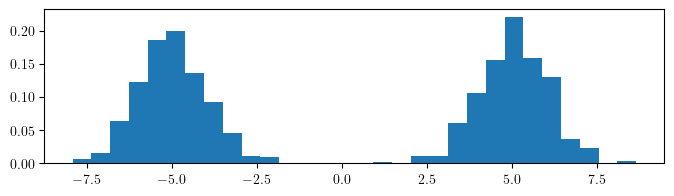

In [3]:
# model 1
theta = torch.tensor([[0.5, -5.0, 5.0, 1.0, 1.0]])
N = 1000
simulator = GaussianMixtureSimulator(theta)

y = simulator.sample((N,))

plt.figure(figsize=(8,2))
plt.hist(y, bins=30, density=True);

# 1.2. Parameter priors

\begin{align*}
    p &\sim U(0,1),\\
    \mu_1 &\sim \mathcal{N}(-5, 4),\\
    \mu_2 &\sim \mathcal{N}(5, 4),\\
    \sigma_{_1}^2 &\sim \Gamma^{-1}(2,2),\\
    \sigma_{2}^2 &\sim \Gamma^{-1}(2, 2)\\
\end{align*}

In [4]:
class Prior():
    def __init__(self, params_p, params_mu_1, params_mu_2, params_sigma2_1, params_sigma2_2):
        
        self.p = D.Uniform(low=params_p['lower'], high=params_p['upper'])

        self.mu1 = D.Normal(loc=params_mu_1['mu'], scale=params_mu_1['sigma'])
        
        self.mu2 = D.Normal(loc=params_mu_2['mu'], scale=params_mu_2['sigma'])

        self.sigma2_1 = D.InverseGamma(params_sigma2_1['alpha'], params_sigma2_1['beta'])
        
        self.sigma2_2 = D.InverseGamma(params_sigma2_2['alpha'], params_sigma2_2['beta'])
        
    def sample(self, shape: torch.Size = ()):
        theta = torch.stack([self.p.sample(shape),
                             self.mu1.sample(shape),
                             self.mu2.sample(shape),
                             self.sigma2_1.sample(shape),
                             self.sigma2_2.sample(shape)
                            ], dim=-1)       
        
        return theta

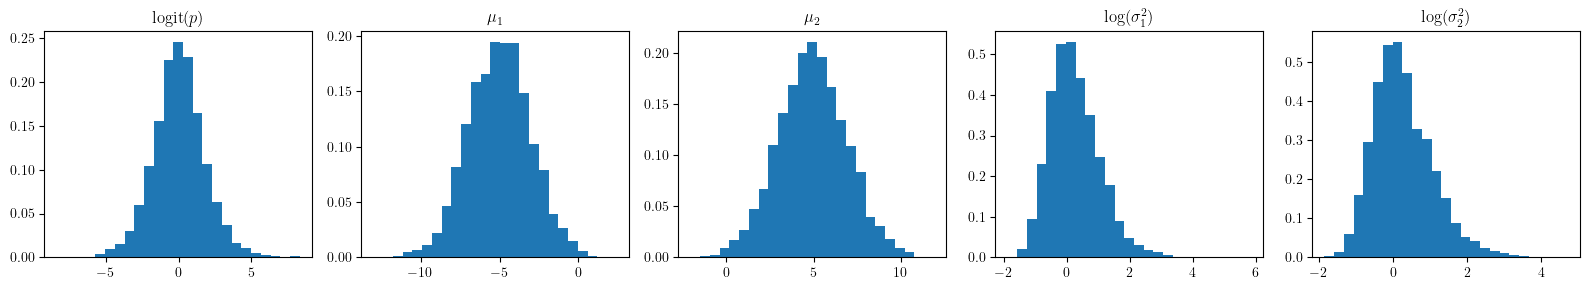

In [5]:
p = {'lower': 0.0, 'upper': 1.0}
mu_1 = {'mu': -5.0, 'sigma': 2.0}
mu_2 = {'mu': 5.0, 'sigma': 2.0}
sigma2_1 = {'alpha': 2.0, 'beta': 2.0}
sigma2_2 = {'alpha': 2.0, 'beta': 2.0}

prior = Prior(p, mu_1, mu_2, sigma2_1, sigma2_2)
N = 5000
theta =  prior.sample((N,))

fig = plt.figure(figsize=(16, 4))

fig.add_subplot(151)
plt.hist(theta[...,0].logit(), bins=25, density=True)
plt.title(r'$\mathrm{logit}(p)$')

fig.add_subplot(152)
plt.hist(theta[...,1], bins=25, density=True)
plt.title(r'$\mu_1$')

fig.add_subplot(153)
plt.hist(theta[...,2], bins=25, density=True)
plt.title(r'$\mu_2$')

fig.add_subplot(154)
plt.hist(theta[...,3].log(), bins=25, density=True)
plt.title(r'$\log(\sigma_{1}^2) $')

fig.add_subplot(155)
plt.hist(theta[...,4].log(), bins=25, density=True)
plt.title(r'$\log(\sigma_{2}^2) $')

plt.tight_layout()
plt.show()

## 3. Neural Varitional inference: Training the Neural Net

### Training

Epoch 10 Loss 1.646629777691199 

Epoch 20 Loss 0.23884806419012602 

Epoch 30 Loss -0.27709132361282685 

Epoch 40 Loss -0.5638738696494674 

Epoch 50 Loss -0.9542936103296874 

Epoch 60 Loss -1.0184321431206713 

Epoch 70 Loss -1.2556567313980427 

Epoch 80 Loss -1.563811767768122 

Epoch 90 Loss -1.734188524037048 

Epoch 100 Loss -1.8755337559836918 



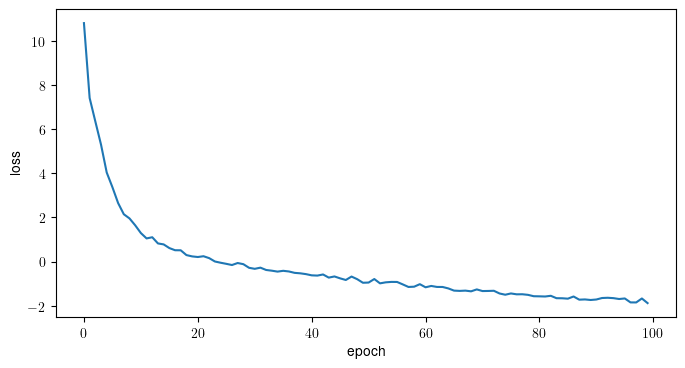

In [6]:
#Explicitly provided seeds for training process
random_seed = 12345  
torch.manual_seed(random_seed)

cuda = torch.cuda.is_available()
if cuda:
    torch.cuda.manual_seed(random_seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
np.random.seed(random_seed)

#========================================== 
#           generating training data
#==========================================
n_prior, n_obs, batchsize = 5000, 400, 80

# sample parameter values from the specified prior
Theta_train = prior.sample((n_prior,))

# draw samples from the simulator conditioned on parameter values
simulator = GaussianMixtureSimulator(Theta_train.unsqueeze(1))

Y_train = simulator.sample((n_obs,))

# put variances on log-scale & p on logit scale
Theta_train[...,0].logit_()
Theta_train[...,3:].log_()

# create a combined dataset and data loader
data_train = torch.utils.data.TensorDataset(Y_train, Theta_train)
data_loader = torch.utils.data.dataloader.DataLoader(data_train, batch_size=batchsize, shuffle=True)


#========================================================
#   Gaussian mixture net with data sorting
#========================================================
gmmnet = hf.MultivariateGaussianMDN(input_size=n_obs, dim=5, K=2, hd=128, num_hidden=2, sort=True).to(device)
loss_fn = lf.GaussianMixtureLoss(aggr='mean')

# # train DNN model
gmmnet = hf.nn_optimizer(model=gmmnet, 
                       data_loader=data_loader,
                       loss_fn=loss_fn,
                       learning_rate=3e-4,
                       eps=0.1, 
                       max_epochs=100,
                       verbose=True,
                       echo_after=10,
                       path='trained_models/gaussian_mixture/dmnet_sorted.pt'
                      )

### Posterior distribution

In [7]:
labels = [r'$\mathrm{logit}(p)$', r'$\mu_1$', r'$\mu_2$', r'$\log(\sigma_{1}^2)$', r'$\log(\sigma_{2}^2) $']

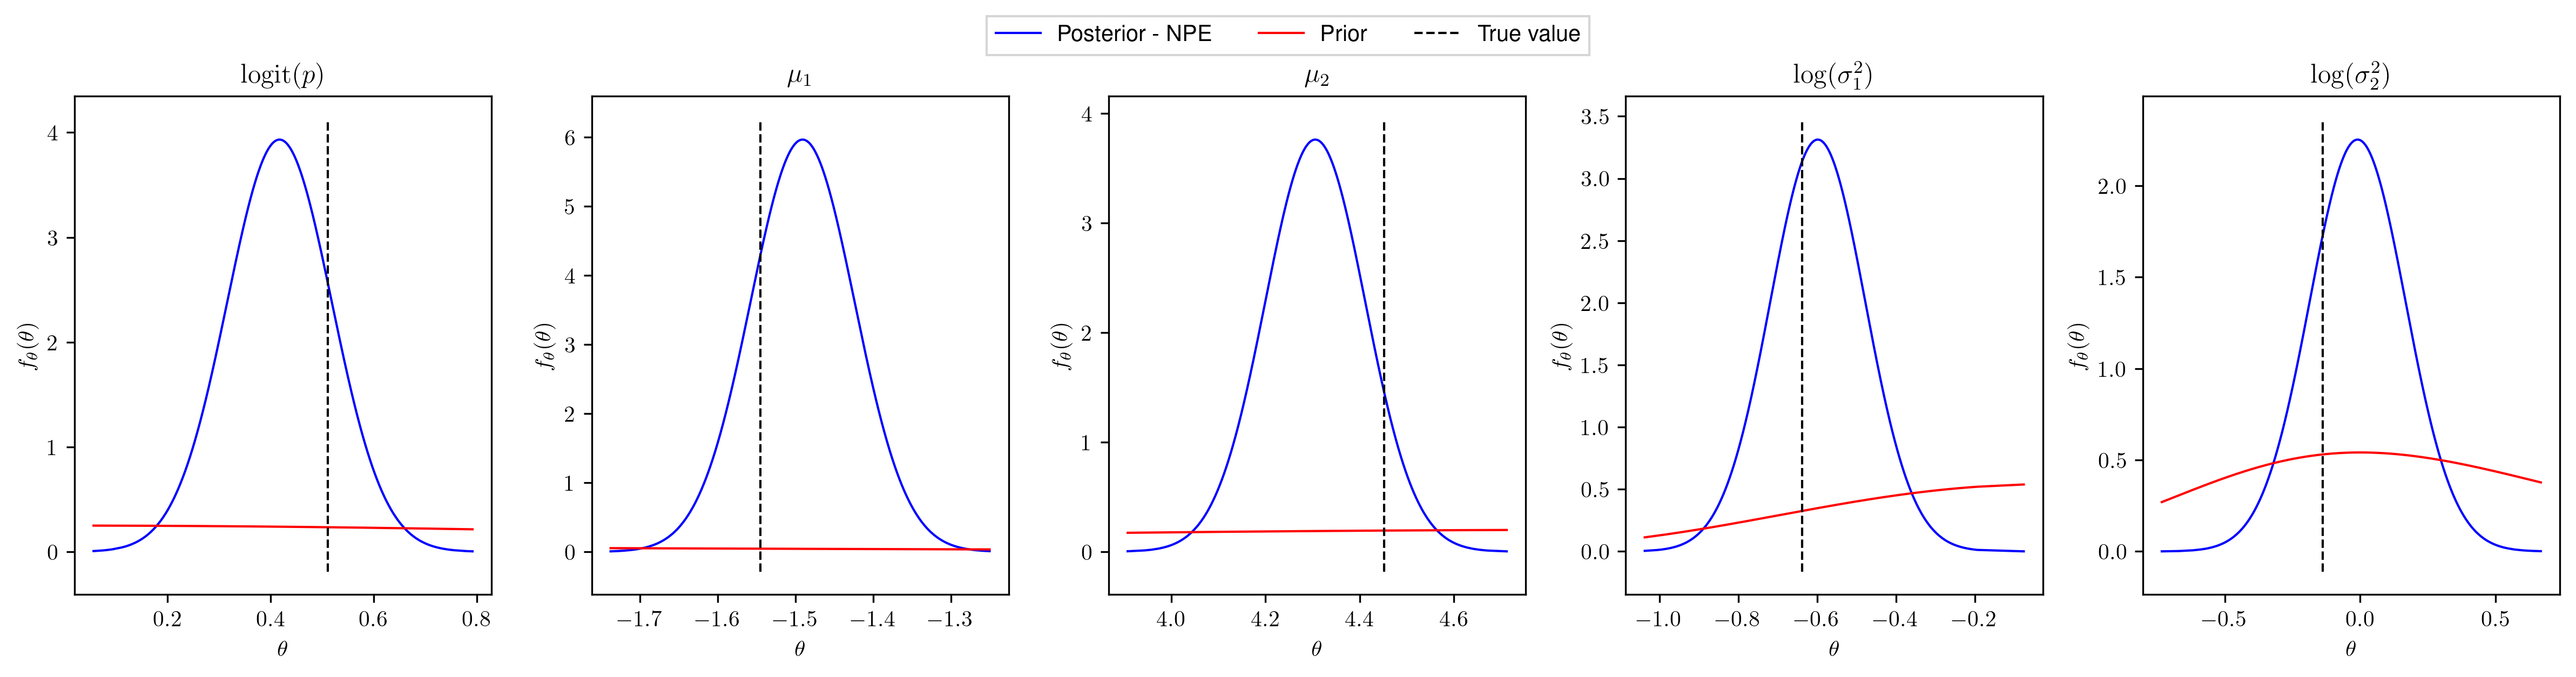

In [8]:
theta = prior.sample((1,))
simulator = GaussianMixtureSimulator(theta)
y = simulator.sample((n_obs,)).unsqueeze(0)

# run the gmmnet
with torch.no_grad():
    mean, chol, coeff = gmmnet(y.to(device))

n_sim, n_component, dim = mean.shape[0], mean.shape[1], mean.shape[2]

# calculate Cholesky factors
chol = torch.vmap(lf.exp_diagonal)(lf.to_triangular(chol.view(n_sim * n_component,  dim * (dim + 1) // 2), dim)).view(n_sim, n_component, dim, dim)

# # caclulate precision matrices
precision = chol @ chol.transpose(2, 3)

# # calculate covariance matrices
covariance = torch.linalg.inv(precision) 

# mixture weights
mix = D.Categorical(coeff)

# plotting
fig = plt.figure(figsize=(16, 4), dpi=300)

for k in range(dim):
    # mixture components
    comp = D.Normal(loc=mean[:,:,k], scale=torch.sqrt(covariance[:,:,k,k]))
    # define the mixture
    gmm = D.MixtureSameFamily(mix, comp) if n_component > 1 else D.Normal(mean[:,:,k].squeeze(), torch.sqrt(covariance[:,:,k,k]).squeeze())

    # draw samples from the approximate posterior
    N = 10000
    theta_k = gmm.sample((N,)).squeeze().sort().values 
    pdf = gmm.log_prob(theta_k).exp().cpu()
    theta_k = theta_k.cpu()

    # prior
    if k == 0:
        theta_inv = theta_k.sigmoid()
        pdf_prior = prior.p.log_prob(theta_inv).exp() * abs(theta_inv * (1 - theta_inv))
    elif k == 1:
        pdf_prior = prior.mu1.log_prob(theta_k).exp()
    elif k == 2:
        pdf_prior = prior.mu2.log_prob(theta_k).exp()
    elif k == 3:
        theta_inv = theta_k.exp()
        pdf_prior = prior.sigma2_1.log_prob(theta_inv).exp() * abs(theta_inv)
    else:
        theta_inv = theta_k.exp()
        pdf_prior = prior.sigma2_2.log_prob(theta_inv).exp() * abs(theta_inv)
   

    # true value    
    theta_k_true = theta[:,k].logit() if k == 0 else theta[:,k] if k < 3 else theta[:,k].log()
    
    fig.add_subplot(1, dim, k+1)
    plt.plot(theta_k, pdf, lw=1., c='b', label='Posterior - NPE')
    plt.plot(theta_k, pdf_prior, lw=1., c='r', label='Prior')
    plt.vlines(x=theta_k_true, ymin=plt.axis()[2], ymax=plt.axis()[3], linestyles='dashed', colors='black', lw=1, label='True value')
    
    plt.xlabel(r'$\theta$')
    plt.ylabel(r'$f_\theta(\theta)$')
    plt.title(labels[k])

handles, legend_labels = plt.gca().get_legend_handles_labels()
fig.legend(handles, legend_labels, loc='upper center', bbox_to_anchor=(0.5, 1.05),
          ncol=3, fancybox=False)
fig.tight_layout()
plt.show()

fig.savefig(fname="figures/gaussian_mixture_2.png", transparent=True, bbox_inches='tight')

### Simulation-based calibration check

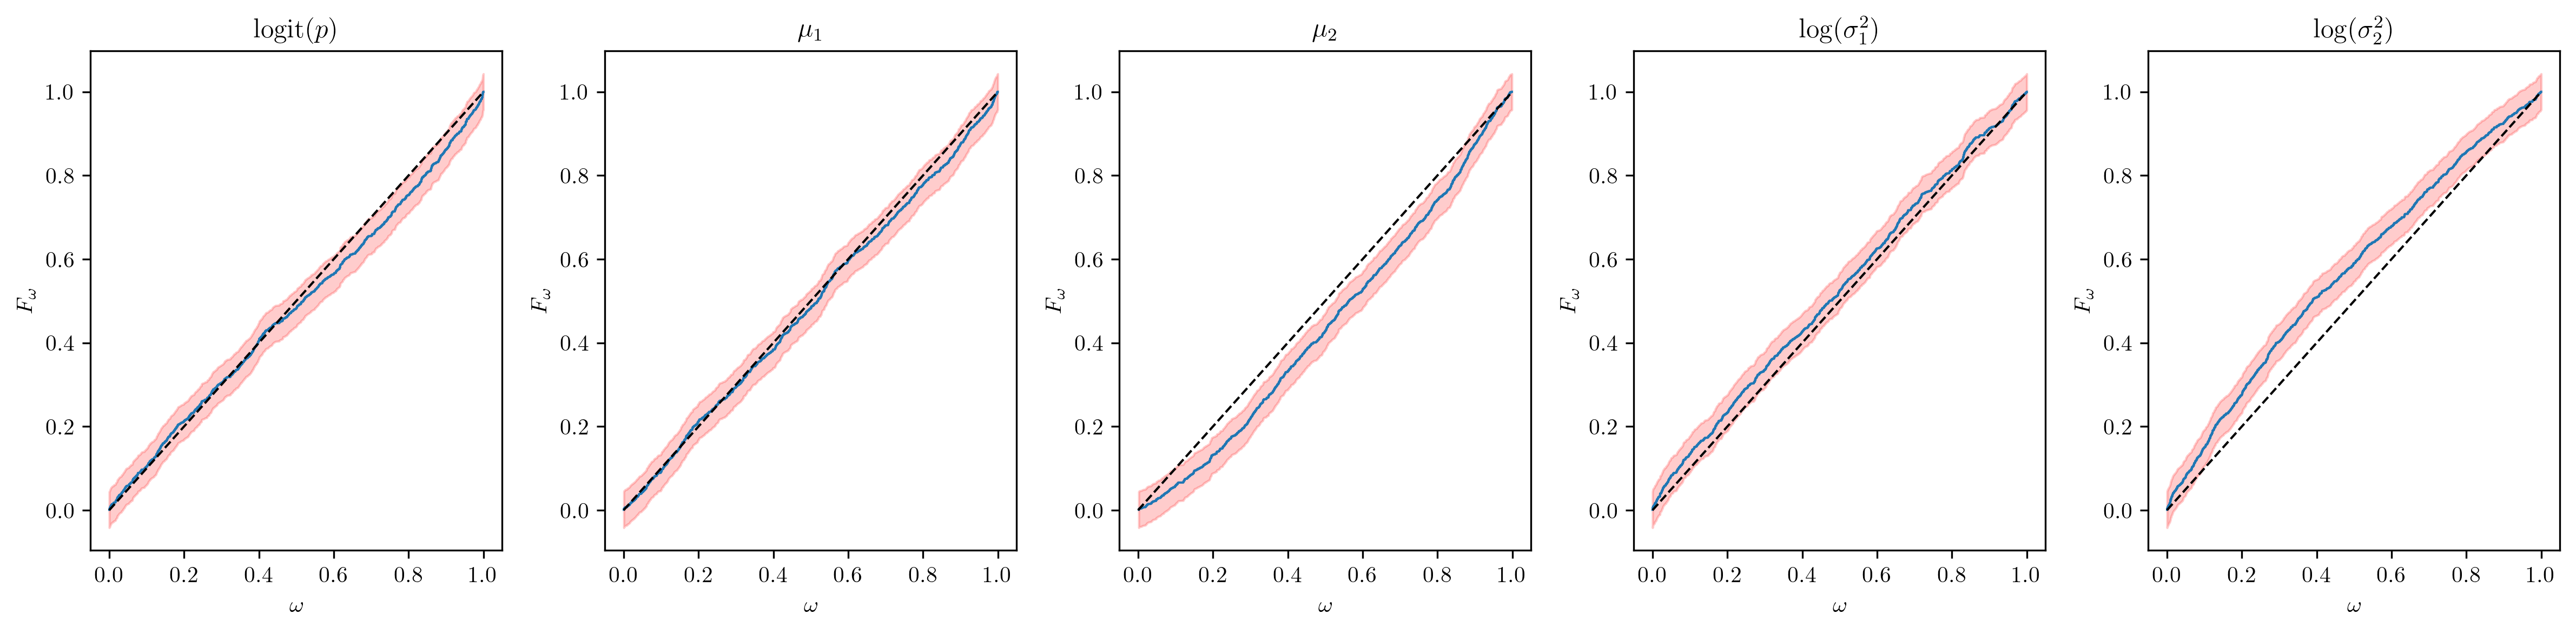

In [9]:
f = hf.sbc_plot(gmmnet, prior, GenerateSimulator, n_obs, 1000, ecdf=True, ecdf_diff=False, 
                 labels=labels, dpi=300, figsize=(16, 4), logitscale=[0], logscale=[3, 4])
f.savefig(fname="figures/gaussian_mixture_sbc.png", transparent=True, bbox_inches='tight')